In [1]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [2]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 31.0 MB/s eta 0:00:00


In [3]:
import os
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.mask import mask as raster_mask
from rasterio.features import rasterize
from scipy.ndimage import zoom
import matplotlib.pyplot as plt

In [4]:

# Lấy các đường dẫn band
band_files = {
    'B2': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B02_10m.jp2",
    'B3': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B03_10m.jp2",
    'B4': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B04_10m.jp2",
    'B8': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B08_10m.jp2",
    'B11': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B11_20m.jp2",
    'B12': "/content/drive/MyDrive/Project_2/2020/T48QWJ_20200218T032811_B12_20m.jp2"
}

In [5]:
# Đọc vùng ROI
roi = gpd.read_file("/content/drive/MyDrive/Project_2/ROI/ROI.geojson")
roi.set_crs(epsg=4326, inplace=True)
roi = roi.to_crs("EPSG:32648")  # CRS của ảnh Sentinel

# Clip và chuẩn hóa bands
clipped_bands = {}
ref_shape = (1186, 1200)
transform = None

In [6]:
for b, path in band_files.items():
    with rasterio.open(path) as src:
        clipped, out_transform = raster_mask(src, roi.geometry, crop=True)
        band_data = clipped[0]

        # Resample nếu band có độ phân giải 20m
        if src.res[0] == 20:
            scale = 2  # 20m → 10m
            band_data = zoom(band_data, scale, order=1)

        # Cắt theo kích thước chuẩn
        band_data = band_data[:ref_shape[0], :ref_shape[1]]

        clipped_bands[b] = band_data

        # Lưu transform từ band đầu tiên
        if transform is None:
            transform = out_transform

In [7]:
# Tính chỉ số NDVI
ndvi = (clipped_bands['B8'] - clipped_bands['B4']) / (clipped_bands['B8'] + clipped_bands['B4'] + 1e-10)

# Stack bands
band_stack = np.stack([clipped_bands[b] for b in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']], axis=-1)
n_rows, n_cols, n_bands = band_stack.shape
X = band_stack.reshape(-1, n_bands)
ndvi = ndvi[:, :, np.newaxis]  # => shape (rows, cols, 1)

# Gộp lại với band_stack
band_stack_with_ndvi = np.concatenate([band_stack, ndvi], axis=-1)
# Chuyển thành (pixels, features)
X_full = band_stack_with_ndvi.reshape(-1, band_stack_with_ndvi.shape[-1])

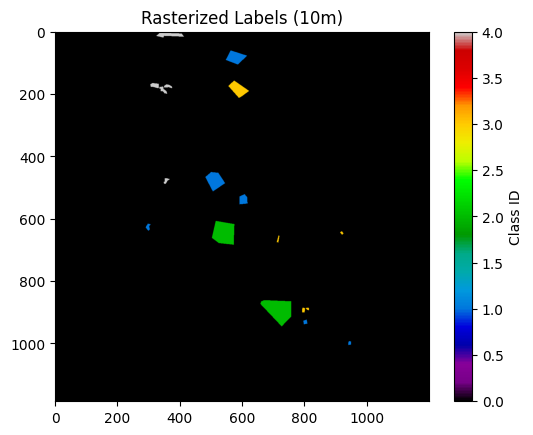

In [8]:
gdf = gpd.read_file('/content/drive/MyDrive/Project_2/Training_data/training_data.shp')
id_to_class = { 1: 'water', 2: 'built_area', 3: 'vegetation', 4: 'others'}
gdf['class'] = gdf['macroclass'].map(id_to_class)
gdf = gdf.to_crs("EPSG:32648")  # Đồng bộ CRS

shapes = [(geom, value) for geom, value in zip(gdf.geometry, gdf['macroclass'])]
label_raster = rasterize(
    shapes=shapes,
    out_shape=ref_shape,
    transform=transform,
    fill=0,
    dtype=np.uint8
)

# Visual kiểm tra raster nhãn
plt.imshow(label_raster, cmap='nipy_spectral')
plt.title("Rasterized Labels (10m)")
plt.colorbar(label="Class ID")
plt.show()

In [9]:
rows, cols = np.where(label_raster > 0)
labels = label_raster[rows, cols]

# Tọa độ không gian cho mỗi điểm raster nhãn
xs, ys = rasterio.transform.xy(transform, rows, cols)
coords = np.column_stack([xs, ys])

In [10]:
features = []
for b in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']:
    band = clipped_bands[b]
    band_values = band[rows, cols]
    features.append(band_values)

# Thêm NDVI vào đặc trưng
features.append(ndvi[rows, cols])

# Tập dữ liệu đầu ra
X = np.column_stack(features)
y = labels

print("X shape:", X.shape)  # (số điểm, 6)
print("y shape:", y.shape)  # (số điểm,)

X shape: (18681, 7)
y shape: (18681,)


In [11]:
import pandas as pd

# Tạo dataframe để quan sát
columns = ['B2', 'B3', 'B4', 'B8', 'B11', 'B12', 'NDVI']
df = pd.DataFrame(X, columns=columns)
df['label'] = y

# Hiển thị 5 dòng đầu tiên
print(df.head())


       B2      B3      B4      B8     B11     B12      NDVI  label
0  1393.0  1547.0  1694.0  2246.0  2797.0  2386.0  0.140102      4
1  1386.0  1545.0  1718.0  2282.0  2812.0  2392.0  0.141000      4
2  1426.0  1597.0  1694.0  2306.0  2821.0  2394.0  0.153000      4
3  1459.0  1562.0  1720.0  2322.0  2829.0  2393.0  0.148936      4
4  1421.0  1546.0  1723.0  2269.0  2836.0  2391.0  0.136774      4


In [12]:
from sklearn.model_selection import train_test_split

# Chia 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Số lượng mẫu training:", len(y_train))
print("Số lượng mẫu test:", len(y_test))


Số lượng mẫu training: 14944
Số lượng mẫu test: 3737


In [13]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, Dense, Flatten, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np



In [14]:
# Normalize and encode
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for Conv1D: (samples, timesteps, features) -> treat features as timesteps
X_scaled = X_scaled.reshape((X_scaled.shape[0], X_scaled.shape[1], 1))

# Convert labels to zero-indexed
y_zero_indexed = y - 1

# Convert labels to one-hot
num_classes = len(np.unique(y))
# Use the zero-indexed labels for to_categorical
y_cat = to_categorical(y_zero_indexed, num_classes)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_cat, test_size=0.2, random_state=42, stratify=y_zero_indexed # Stratify using zero-indexed labels
)

In [50]:
# Build model
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(X_train.shape[1], 1)), # Adjusted for Conv1D
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=32, kernel_size=2, activation="relu"), # Adjusted for Conv1D
    # MaxPooling1D is typically used with Conv1D, but not always necessary
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=16, kernel_size=2, activation="relu"), # Adjusted for Conv1D
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    # The number of units in the output layer should be equal to the number of classes
    Dense(num_classes, activation="softmax") # Adjusted output layer for number of classes
])
model.summary()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=30, batch_size=128)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)              │ (None, 6, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 6, 64)          │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_28 (Conv1D)              │ (None, 5, 32)          │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 5, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 5, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_29 (Conv1D)              │ (None, 4, 16)          │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 4, 16)          │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 4, 16)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_12 (Flatten)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,804 (73.45 KB)

 Trainable params: 18,580 (72.58 KB)

 Non-trainable params: 224 (896.00 B)

Epoch 1/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.6522 - loss: 0.8678 - val_accuracy: 0.8306 - val_loss: 0.7120
Epoch 2/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8665 - loss: 0.3326 - val_accuracy: 0.7656 - val_loss: 0.5342
Epoch 3/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9066 - loss: 0.2385 - val_accuracy: 0.8817 - val_loss: 0.2645
Epoch 4/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.9279 - loss: 0.1943 - val_accuracy: 0.9524 - val_loss: 0.1230
Epoch 5/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9416 - loss: 0.1633 - val_accuracy: 0.9572 - val_loss: 0.1057
Epoch 6/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9431 - loss: 0.1503 - val_accuracy: 0.9714 - val_loss: 0.0779
Epoch 7/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9509 - loss: 0.1327 - val_accuracy: 0.9716 - val_loss: 0.0728
Epoch 8/30
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9528 - loss: 0.1310 - val_accur

In [51]:

# Evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Use the values from the id_to_class dictionary for target names
print(classification_report(y_true, y_pred_classes, target_names=list(id_to_class.values())))


117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

       water       1.00      1.00      1.00      1028
  built_area       0.99      0.99      0.99      1915
  vegetation       0.96      0.87      0.91       423
      others       0.88      0.98      0.93       371

    accuracy                           0.98      3737
   macro avg       0.96      0.96      0.96      3737
weighted avg       0.98      0.98      0.98      3737



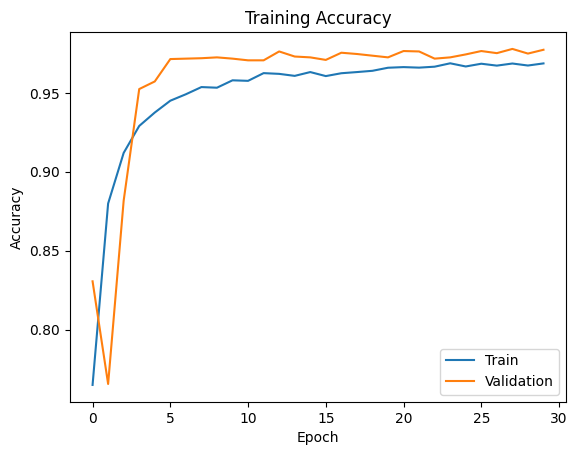

In [52]:
# Plot training history
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Visualize

In [53]:
from rasterio.features import geometry_mask

# Tạo mask nhị phân từ ROI (True = ngoài ROI, False = trong ROI)
roi_mask = geometry_mask(
    roi.geometry,
    out_shape=ref_shape,
    transform=transform,
    invert=True
)

44475/44475 ━━━━━━━━━━━━━━━━━━━━ 77s 2ms/step


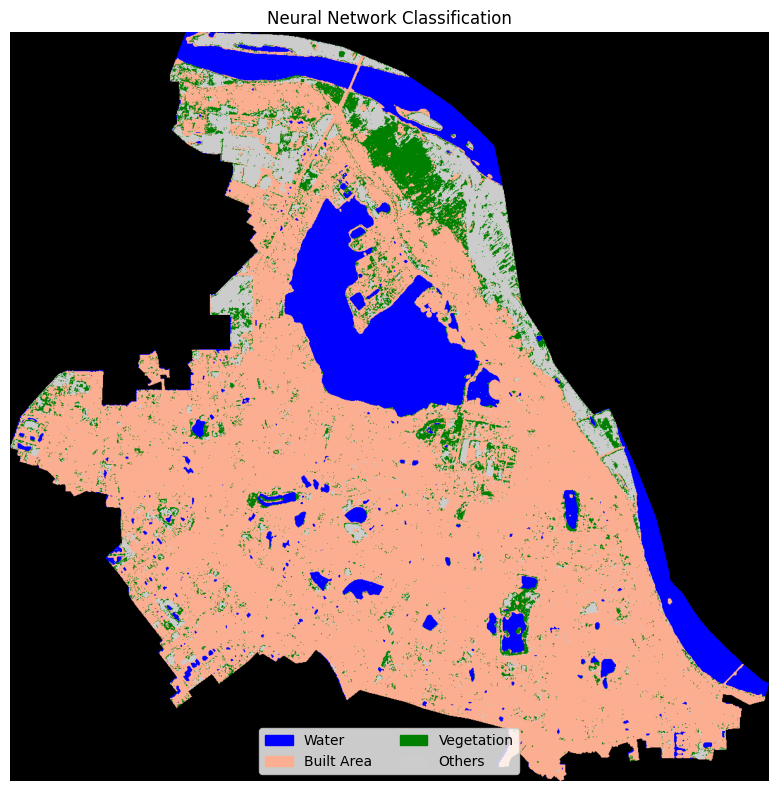

In [54]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
import numpy as np




scaler_for_full = StandardScaler()
X_original = np.column_stack([clipped_bands[b][rows, cols] for b in ['B2', 'B3', 'B4', 'B8', 'B11', 'B12']] + [ndvi[rows, cols]])
scaler_for_full.fit(X_original)


# Apply the scaler to X_full
X_full_scaled = scaler_for_full.transform(X_full)

# Reshape for Conv1D: (samples, timesteps, features)
X_full_scaled = X_full_scaled.reshape((X_full_scaled.shape[0], X_full_scaled.shape[1], 1))

# Step 2: Get predictions using the preprocessed data

# Step 3: Predict on the scaled and reshaped X_full
classified_predictions = model.predict(X_full_scaled) # Output shape: (total_pixels, num_classes)
classified_classes = np.argmax(classified_predictions, axis=1) # Convert probabilities to class index

# Step 4: Reshape the class indices back to the original image shape
classified_nn_reshaped = classified_classes.reshape(ref_shape) + 1 # Add 1 to match original class IDs

# Apply the ROI mask
masked_classified_nn = np.where(roi_mask, classified_nn_reshaped, 0)  # 0 outside ROI

cmap = mcolors.ListedColormap(['black', 'blue', '#fcae91', 'green', '#cccccc'])  # 0: ngoài ROI
bounds = [0, 0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(8, 8))
plt.imshow(masked_classified_nn, cmap=cmap, norm=norm)
plt.title("Neural Network Classification") # Updated title
plt.axis("off")

# Chú thích: không cần hiển thị '0'
labels = ['Water', 'Built Area', 'Vegetation', 'Others']
# Map indices 1-4 to colors in the colormap (which correspond to indices 1-4 in the cmap definition)
handles = [plt.Rectangle((0, 0), 1, 1, color=cmap(i)) for i in range(1, 5)]
plt.legend(handles, labels, loc='lower center', ncol=2, fontsize=10)

plt.tight_layout()
plt.show()

In [23]:
!pip install visualkeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 15.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")
/usr/local/lib/python3.11/dist-packages/visualkeras/layered.py:86: UserWa

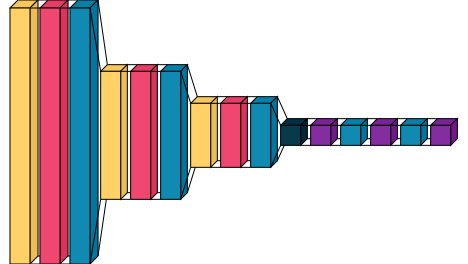

In [47]:
import visualkeras
model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation="relu", input_shape=(X_train.shape[1], 1)), # Adjusted for Conv1D
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=32, kernel_size=2, activation="relu"), # Adjusted for Conv1D
    # MaxPooling1D is typically used with Conv1D, but not always necessary
    BatchNormalization(),
    Dropout(0.2),

    Conv1D(filters=16, kernel_size=2, activation="relu"), # Adjusted for Conv1D
    BatchNormalization(),
    Dropout(0.2),

    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(128, activation="relu"),
    Dropout(0.5),
    # The number of units in the output layer should be equal to the number of classes
    Dense(num_classes, activation="softmax") # Adjusted output layer for number of classes
])

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)

In [20]:
import rasterio
import geopandas as gpd
from rasterio.mask import mask as raster_mask
import numpy as np

# Define the path to the ground truth raster
ground_truth_path = "/content/drive/MyDrive/Project_2/test_data/test_data_1.tif"



# Load and clip the ground truth raster by ROI
try:
    with rasterio.open(ground_truth_path) as src_gt:
        gt_clipped, gt_transform = raster_mask(src_gt, roi.geometry, crop=True)
        ground_truth_data = gt_clipped[0] # Assuming a single band ground truth raster

        print(f"Shape of the clipped ground truth data: {ground_truth_data.shape}")


except rasterio.errors.CRSError as e:
    print(f"CRS Error loading or clipping ground truth: {e}")
    print("Please ensure the ground truth raster CRS is compatible with the ROI or reproject it.")
except Exception as e:
    print(f"An error occurred loading or clipping ground truth: {e}")

Shape of the clipped ground truth data: (1186, 1200)


Evaluating model on 715081 ground truth pixels...

Classification Report on External Ground Truth:
              precision    recall  f1-score   support

       water       0.97      1.00      0.99    104724
  built_area       0.98      0.97      0.98    489552
  vegetation       0.78      0.77      0.77     53367
      others       0.86      0.90      0.88     67438

    accuracy                           0.95    715081
   macro avg       0.90      0.91      0.90    715081
weighted avg       0.95      0.95      0.95    715081



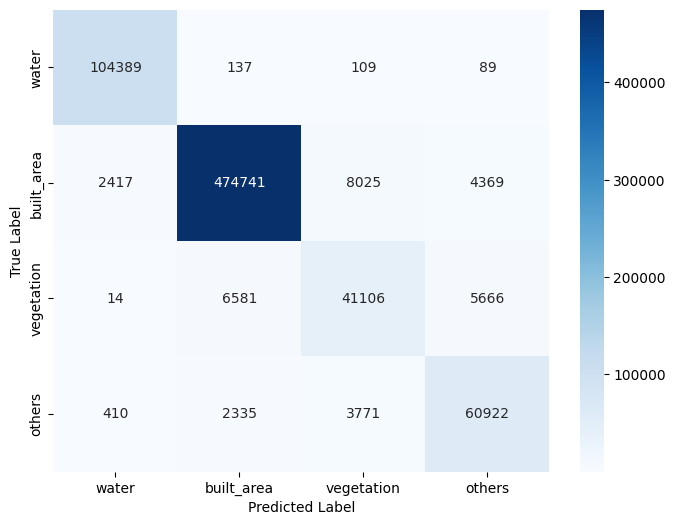


Overall Accuracy on External Ground Truth: 0.9526


In [55]:
import rasterio
import numpy as np
import geopandas as gpd
from rasterio.mask import mask as raster_mask
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Define the path to the ground truth raster
ground_truth_path = "/content/drive/MyDrive/Project_2/test_data/classified_result.tif"

# 1. Load and clip the ground truth raster
try:
    with rasterio.open(ground_truth_path) as src_gt:
        # Ensure ground truth is in the same CRS as the ROI and Sentinel data
        gt_clipped, gt_transform = raster_mask(src_gt, roi.geometry, crop=True)
        ground_truth_data = gt_clipped[0]

        # Reshape the ground truth data to match the reference shape if necessary
        # This is crucial for pixel-wise comparison.
        if ground_truth_data.shape != ref_shape:
            print(f"Ground truth shape {ground_truth_data.shape} does not match reference shape {ref_shape}. Attempting to resize.")
            # This is a simple nearest-neighbor resize; more advanced methods might be needed depending on data
            from skimage.transform import resize
            ground_truth_data_resized = resize(ground_truth_data, ref_shape, order=0, preserve_range=True).astype(src_gt.dtype)
            ground_truth_data = ground_truth_data_resized
            gt_transform = transform # Assume the transform is the same after resizing to ref_shape

except rasterio.errors.CRSError as e:
    print(f"CRS Error loading or clipping ground truth: {e}")
    print("Please ensure the ground truth raster CRS is compatible with the ROI or reproject it.")
    # Handle the error appropriately, perhaps skip evaluation or try reprojection
except Exception as e:
    print(f"An error occurred loading or clipping ground truth: {e}")
    # Handle other potential errors

# 2. Extract Ground Truth Labels and corresponding Predictions

valid_gt_pixels = ground_truth_data > 0 # Assuming ground truth classes are 1, 2, 3, 4 and 0 is no-data

# Get the ground truth labels for the valid pixels
true_labels = ground_truth_data[valid_gt_pixels].flatten()

# Get the corresponding predicted labels from your full classification result
# Ensure classified_nn_reshaped has the same dimensions as ground_truth_data
predicted_labels = classified_nn_reshaped[valid_gt_pixels].flatten()

# 3. Compare Predictions and Ground Truth & 4. Calculate Evaluation Metrics

# Make sure both arrays have the same number of elements
if true_labels.shape[0] != predicted_labels.shape[0]:
    print("Error: Number of valid ground truth pixels does not match the number of predicted pixels.")
    print(f"True labels shape: {true_labels.shape}")
    print(f"Predicted labels shape: {predicted_labels.shape}")
else:
    print(f"Evaluating model on {len(true_labels)} ground truth pixels...")
    # Calculate confusion matrix

    possible_labels = sorted(np.unique(np.concatenate((true_labels, predicted_labels))))

    cm = confusion_matrix(true_labels, predicted_labels, labels=possible_labels)

    target_names = [id_to_class[i] for i in possible_labels if i in id_to_class]

    print("\nClassification Report on External Ground Truth:")
    print(classification_report(true_labels, predicted_labels, labels=possible_labels, target_names=target_names))

    # Optional: Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.show()

    # Optional: Calculate overall accuracy
    overall_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    print(f"\nOverall Accuracy on External Ground Truth: {overall_accuracy:.4f}")